In [136]:
import sys
from tkinter import Y
import numpy as np
import pandas as pd
import torch
import gpytorch
import plotly.express as px
import matplotlib.pyplot as plt
sys.path.append('..')
sys.path.insert(0, '../src')

In [137]:
# custom imports
from model import GPModel
from GPy.models import GPRegression
from acq_funcs import EI, PI, cust_acq, thompson
from plotter import vis_pred, vis_acq

### Data Read and Pre-processing

In [138]:
# read data and display
def read_dat(dir="/Users/valenetjong/Bayesian-Optimization-Ferroelectrics/data/",
            src_file = "Bolometer_readings_PulseForge.xlsx", sheet= "Combined"):
    file = dir + src_file
    fe_data = pd.read_excel(file, sheet_name=sheet, usecols=['Energy density new cone (J/cm^2)',
                            'Time (ms)','2 Qsw/(U+|D|) 1e6cycles'])
    fe_data.dropna(subset=['2 Qsw/(U+|D|) 1e6cycles'], inplace=True)
    fe_data = fe_data[fe_data['2 Qsw/(U+|D|) 1e6cycles']!= 0]
    return fe_data

def display_data(fe_data):
    """
    [display_data(fe_data)] creates a cross-section scatter plot of all combinations
    of the four input parameters and single output parameter.
    """
    # plot each cross-section
    fig = px.scatter_matrix(fe_data, dimensions=['Energy density new cone (J/cm^2)', 
    "Time (ms)", "2 Qsw/(U+|D|) 1e6cycles"], color_discrete_sequence=["#72356c"]*23)
    fig.update_layout(template="ggplot2")
    # fig.update_layout(margin=dict(r=20, l=10, b=10, t=10))
    fig.update_layout(width = 800, height=800)
    fig.show()

In [139]:
fe_data = read_dat()
print(fe_data)
display_data(fe_data)

    Time (ms)  Energy density new cone (J/cm^2)  2 Qsw/(U+|D|) 1e6cycles
4         0.5                              2.73                 0.873026
5         0.5                              3.40                 2.677245
6         1.0                              3.79                 1.699015
7         1.0                              6.44                 3.805053
8         1.5                              5.36                 3.334856
9         1.5                              8.99                 4.535153
11        5.0                              8.80                 1.362510
13        5.0                             14.67                 3.841291
19        0.5                              5.24                 1.201357
22        5.0                             14.89                 3.513652
23        2.0                             10.13                 3.470871
24        0.5                              4.51                 0.263298
25        0.5                              5.37    

In [140]:
# define scaler and inverse scaling
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler =  MinMaxScaler()

def un_norm_x(train_x, test_grid, scaler):
    return scaler.inverse_transform(train_x), scaler.inverse_transform(test_grid)    

In [141]:
from torch.utils.data import DataLoader, random_split

def datasetmaker(fe_data, train_ratio=1.0):
    """
    [datasetmaker(fe_data)] filters and transforms the data in pandas df [fe_data] 
    into two tensors, [train_x] for input and [train_y] for output tensors. 
    """
    # filter training data 
    energy_den = fe_data['Energy density new cone (J/cm^2)'].values
    time = fe_data['Time (ms)'].values
    x_dat = torch.Tensor(np.array([time, energy_den])).T
    y_dat = torch.Tensor(fe_data['2 Qsw/(U+|D|) 1e6cycles'].values)

    # scale inputs
    scaler.fit(x_dat)
    x_dat = torch.Tensor(scaler.transform(x_dat))

    # split train and test set
    train_size = int(train_ratio * len(x_dat))  # train_ratio% for training
    train_x, test_x = x_dat[:train_size], x_dat[train_size:]
    train_y, test_y = y_dat[:train_size], y_dat[train_size:]
    return x_dat, train_x, test_x, train_y, test_y

In [142]:
# make training data, maintain params to de-normalize
# x_sd_mean, y_sd_mean, train_x, train_y = datasetmaker(fe_data)
x_dat, train_x, test_x, train_y, test_y = datasetmaker(fe_data)


### Grid/Parameter Space

In [143]:
# create grid for grid search
def grid_helper(grid_size, num_params, grid_bounds):
    """
    [grid_helper(grid_size, num_params, grid_bounds)] returns a grid of dimensions
    [grid_size] by [num_params], which dictates the parameter space for GP to be 
    conducted over. 
    """
    grid = torch.zeros(grid_size, num_params)
    f_grid_diff = lambda i, x, y : float((x[i][1] - x[i][0]) / (y-2))
    for i in range(num_params):
        grid_diff = f_grid_diff(i, grid_bounds, grid_size)
        grid[:, i] = torch.linspace(grid_bounds[i][0] - grid_diff, 
                                    grid_bounds[i][1] + grid_diff, grid_size)
    return grid

def grid_maker(x_dat, num_points=30):
    """
    [grid_maker(x_dat, num_points=30)] creates grids to be used for gaussian 
    process predictions. It outputs the dimension of the grid [num_params], 
    paramater space grid [test_grid], and [test_arr].
    """
    # define grid between bounds of RTA time, RTA temp
    num_params = x_dat.size(dim=1)
    grid_bounds = [(x_dat[:,i].min(), x_dat[:,i].max()) for i in range(num_params)]

    # set up test_grid for predictions
    test_grid = grid_helper(num_points, num_params, grid_bounds)

    # create n-D grid with n = num_params
    args = (test_grid[:, i] for i in range(num_params))
    test_arr = torch.cartesian_prod(*args)
    return grid_bounds, num_params, test_grid, test_arr


In [144]:
# create grid based on parameter space for search
grid_bounds, num_params, test_grid, test_arr = grid_maker(x_dat)

### Noise Calculations

Our figure of merit, fom, is $2 Q_{sw}/(U+|D|),$ so error propagation would result in a error of $\sigma_{fom} = |fom|\sqrt{{(\sigma_{Q_{sw}}/Q_{sw}})^2+{(\sigma_U^2 + \sigma_{|D|}^2)/(U+|D|)^2)}}$. We have data for $2Pr$ measurements wrt device area. Using the $10\mu$ m $\times 10\mu$ m data, we approximate the error for the figure of merit as simply $\sigma_{2Pr}$, as we do not have $\sigma_U$ or $\sigma_D.$ 


In [145]:
fn = "/Users/valenetjong/Bayesian-Optimization-Ferroelectrics/data/P vs area.xlsx"
excel_file = pd.read_excel(fn, sheet_name='Sheet1')
col_2Pr_10by10 = excel_file['10umx10um']
sd = col_2Pr_10by10.std()/col_2Pr_10by10.mean()
print(sd)
print(col_2Pr_10by10)

0.04469365441252401
0     34.57379
1     35.96416
2     33.16083
3     35.96861
4     37.10497
5     35.86549
6     35.81341
7     33.01597
8     35.71753
9     38.37434
10    34.11144
11    33.57596
12    35.15750
13    35.01515
14    36.01072
15    37.04952
16    36.48895
17    35.63807
18    37.36247
19    39.05057
Name: 10umx10um, dtype: float64


### Initialize Model

In [253]:
# configuration parameters for training
class Config():
    def __init__(self):
        self.epochs = 5000
        self.kernel = "matern"
        self.lr = 0.005
        self.lscale_1 = 1.0
        self.lscale_2 = 1.0
        self.lscale_3 = None
        self.lscale_4 = None
        self.dim = 2
        self.noise = 0.1

config = Config()

In [254]:
# make model
def kernel_func(config_kernel, num_params, lscale):
    """
    [kernel_func(config_kernel, num_params, lscale)] returns kernel function with 
    dimensions specified by [num_params]. 
    """
    if config_kernel == "rbf":
        return gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(ard_num_dims=num_params))
    elif config_kernel == "matern":
        return gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(ard_num_dims=num_params, 
        lengthscale = torch.tensor(lscale), nu=0.5))

def make_model(train_x, train_y, num_params, config):
    """
    [make_model(train_x, train_y, num_params, config)] returns likelihood and 
    model with lengthscale, noise, kernel function specified by sweeps. 
    """
    if config.dim == 2:
        lscale = [config.lscale_1, config.lscale_2]
    elif config.dim == 4:
        lscale = [config.lscale_1, config.lscale_2, config.lscale_3, config.lscale_4]
    kernel = kernel_func(config.kernel, num_params, lscale)
    
    print(kernel)
    num_samples = len(train_x)
    noise = config.noise*torch.ones(num_samples)
    likelihood = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(noise=noise)
    model = GPModel(train_x, train_y, likelihood, kernel)

    return likelihood, model, lscale
    

In [255]:
def intermediate_plot(f, ax, obs, title):
    im = ax.imshow(obs.mean.view(30, 30), aspect='equal',
                extent=[grid_bounds[0][0].item(), grid_bounds[0][1].item(),
                            grid_bounds[1][0].item(), grid_bounds[1][1].item()])
    f.colorbar(im)
    ax.set_title(title)

### GP Training and Eval

In [256]:
# training and evaluation
def train(train_x, train_y, num_params, config):
    likelihood, model, lscale = make_model(train_x, train_y, num_params, config)
    model.covar_module.base_kernel.lengthscale = torch.Tensor(lscale)
    training_iter = config.epochs
    # model.covar_module.base_kernel.raw_lengthscale.requires_grad_(False) # disallow training of lengthscale
    
    
    # place both the model and likelihood in training mode
    model.train(), likelihood.train()

    # use Adam
    optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)

    # set GP loss as the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    loss_lst = []

    for i in range(1, training_iter+1):
        optimizer.zero_grad()
        output = model(train_x)

        # backpropagate error
        loss = -mll(output, train_y)
        loss.backward()

        if i==1 or i % 500 == 0: 
            print('Iter %d/%d - Loss: %.3f  lengthscale1: %s   noise: %s' % (
                    i, training_iter, loss.item(), 
                    model.covar_module.base_kernel.lengthscale.detach().numpy(),
                    model.likelihood.noise.detach().numpy()
                    )) 
            loss_lst.append(loss.item())

        # if i % 1000 == 0:
        # # get a quick snapshot of intermediate 
        #     model.eval()
        #     likelihood.eval()
        #     with torch.no_grad(), gpytorch.settings.fast_pred_var():
        #         obs = likelihood(model(test_arr))
        #         f, ax = plt.subplots(1, 1, figsize=(4,3))
        #         intermediate_plot(f, ax, obs, f'iter {i+1}/{training_iter}')
        #     model.train()
        #     likelihood.train()
        optimizer.step()
        
    print(model.covar_module.outputscale.detach().numpy())
    return likelihood, model, loss_lst

def eval_mod(likelihood, model, test_arr):
    """ 
    [eval_mod(likelihood, model, test_arr)] evaluates GP model. 
    """
    model.eval(), likelihood.eval()
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        obs = likelihood(model(test_arr), noise=(torch.ones(len(test_arr))*config.noise))
    return obs

In [257]:
# train model and evaluate
likelihood, model, loss_lst = train(train_x, train_y, num_params, config)

obs = eval_mod(likelihood, model, test_arr)

ScaleKernel(
  (base_kernel): MaternKernel(
    (raw_lengthscale_constraint): Positive()
  )
  (raw_outputscale_constraint): Positive()
)
Iter 1/5000 - Loss: 4.176  lengthscale1: [[1. 1.]]   noise: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1]
Iter 500/5000 - Loss: 1.847  lengthscale1: [[0.20328146 0.15323904]]   noise: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1]
Iter 1000/5000 - Loss: 1.634  lengthscale1: [[0.07903071 0.0632174 ]]   noise: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1]
Iter 1500/5000 - Loss: 1.601  lengthscale1: [[0.04432219 0.04380639]]   noise: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1]
Iter 2000/5000 - Loss: 1.588  lengthscale1: [[0.0306632  0.03470687]]   noise: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1]
Iter 2500/50

### GP Training Results

In [258]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
from scipy.stats import spearmanr
import matplotlib.pyplot as plt 
from plotter import prettyplot

In [259]:
# get error metrics
def get_err(train_y, y_preds_mean):
    rmse = np.sqrt(mean_squared_error(train_y, y_preds_mean))
    mae = mean_absolute_error(train_y,  y_preds_mean)
    spearman = spearmanr(train_y, y_preds_mean)[0]
    r2 = r2_score(train_y, y_preds_mean)
    return [round_three(i) for i in [rmse, mae, spearman, r2]]

def plot_err(axes, train_y, y_preds_mean, y_uncer, err_vals, train_or_test, fs):
    # training versus actuals plot: make plot, set title and axes values
    ax = axes[0]
    ax.scatter(train_y, y_preds_mean, color = "#72356c")
    low_lim, upp_lim = int(min(train_y).item()), int(np.ceil(max(train_y).item()))
    ax.plot(np.linspace(low_lim, upp_lim), np.linspace(low_lim, upp_lim), 'k--')
    ax.set_xlim(low_lim, upp_lim)
    ax.set_ylim(low_lim, upp_lim)
    
    # sort train_y to enable fill_between to exhibit correct functionality
    # plot 95% confidence interval
    sorted_train_y, sorted_indices_y = np.sort(train_y), np.argsort(train_y)
    low_bound = (y_preds_mean-2*y_uncer)[sorted_indices_y]
    upp_bound = (y_preds_mean+2*y_uncer)[sorted_indices_y]
    ax.fill_between(sorted_train_y, low_bound, upp_bound, color = "grey", alpha = 0.3, label="95% confidence interval")    
    ax.set_xlabel('Ground Truth 2 Qsw/(U+|D|) 1e6', fontsize = fs)
    ax.set_ylabel('Prediction 2 Qsw/(U+|D|) 1e6', fontsize = fs)
    title_type = "Training" if train_or_test == "train" else "Test"
    ax.set_title('GP ' + title_type + ' Results' + " (MAE=%.2f" % err_vals[1]+' [%])', fontsize = fs)
    ax.legend()

def plot_training_loss(axes, loss_lst, fs):
    ax = axes[1]
    ax.plot(np.arange(len(loss_lst))*500,loss_lst, 'o-', color = "#72356c")
    ax.set_xlabel('Epoch', fontsize = fs)
    ax.set_ylabel('Marginal Log Likelihood Loss', fontsize = fs)
    ax.set_title('Training Loss' + " (Loss=%.2f" % loss_lst[-1] + ')', fontsize = fs)

def plot_gp_res(train_y, y_preds_mean, loss_lst, y_uncer, train_or_test="train"):
    prettyplot()
    fig, axes = plt.subplots(1, 3, figsize=(5.5*3, 4.5))
    fs = 14

    # print error metrics
    err_vals = get_err(train_y, y_preds_mean)
    data = {'Metric': ['RMSE', 'MAE', 'Spearman', 'R² score'], 'Value': err_vals}
    df = pd.DataFrame(data)
    print(df)

    # plot error, training/testing loss
    plot_err(axes, train_y, y_preds_mean, y_uncer, err_vals, train_or_test, fs)
    if loss_lst: plot_training_loss(axes, loss_lst, fs)
    else: axes[1].axis("off")
    axes[2].axis("off")

    for i in range(len(axes)):
        axes[i].tick_params(direction='in', length=5, width=1, labelsize = fs*.8)
    plt.subplots_adjust(wspace = 0.4)

    plt.show()

     Metric  Value
0      RMSE  0.090
1       MAE  0.078
2  Spearman  0.996
3  R² score  0.995


/Users/valenetjong/opt/anaconda3/envs/FEGP/lib/python3.9/site-packages/gpytorch/models/exact_gp.py:274: GPInputWarning:

The input matches the stored training data. Did you forget to call model.train()?

/Users/valenetjong/opt/anaconda3/envs/FEGP/lib/python3.9/site-packages/gpytorch/likelihoods/gaussian_likelihood.py:270: GPInputWarning:

You have passed data through a FixedNoiseGaussianLikelihood that did not match the size of the fixed noise, *and* you did not specify noise. This is treated as a no-op.



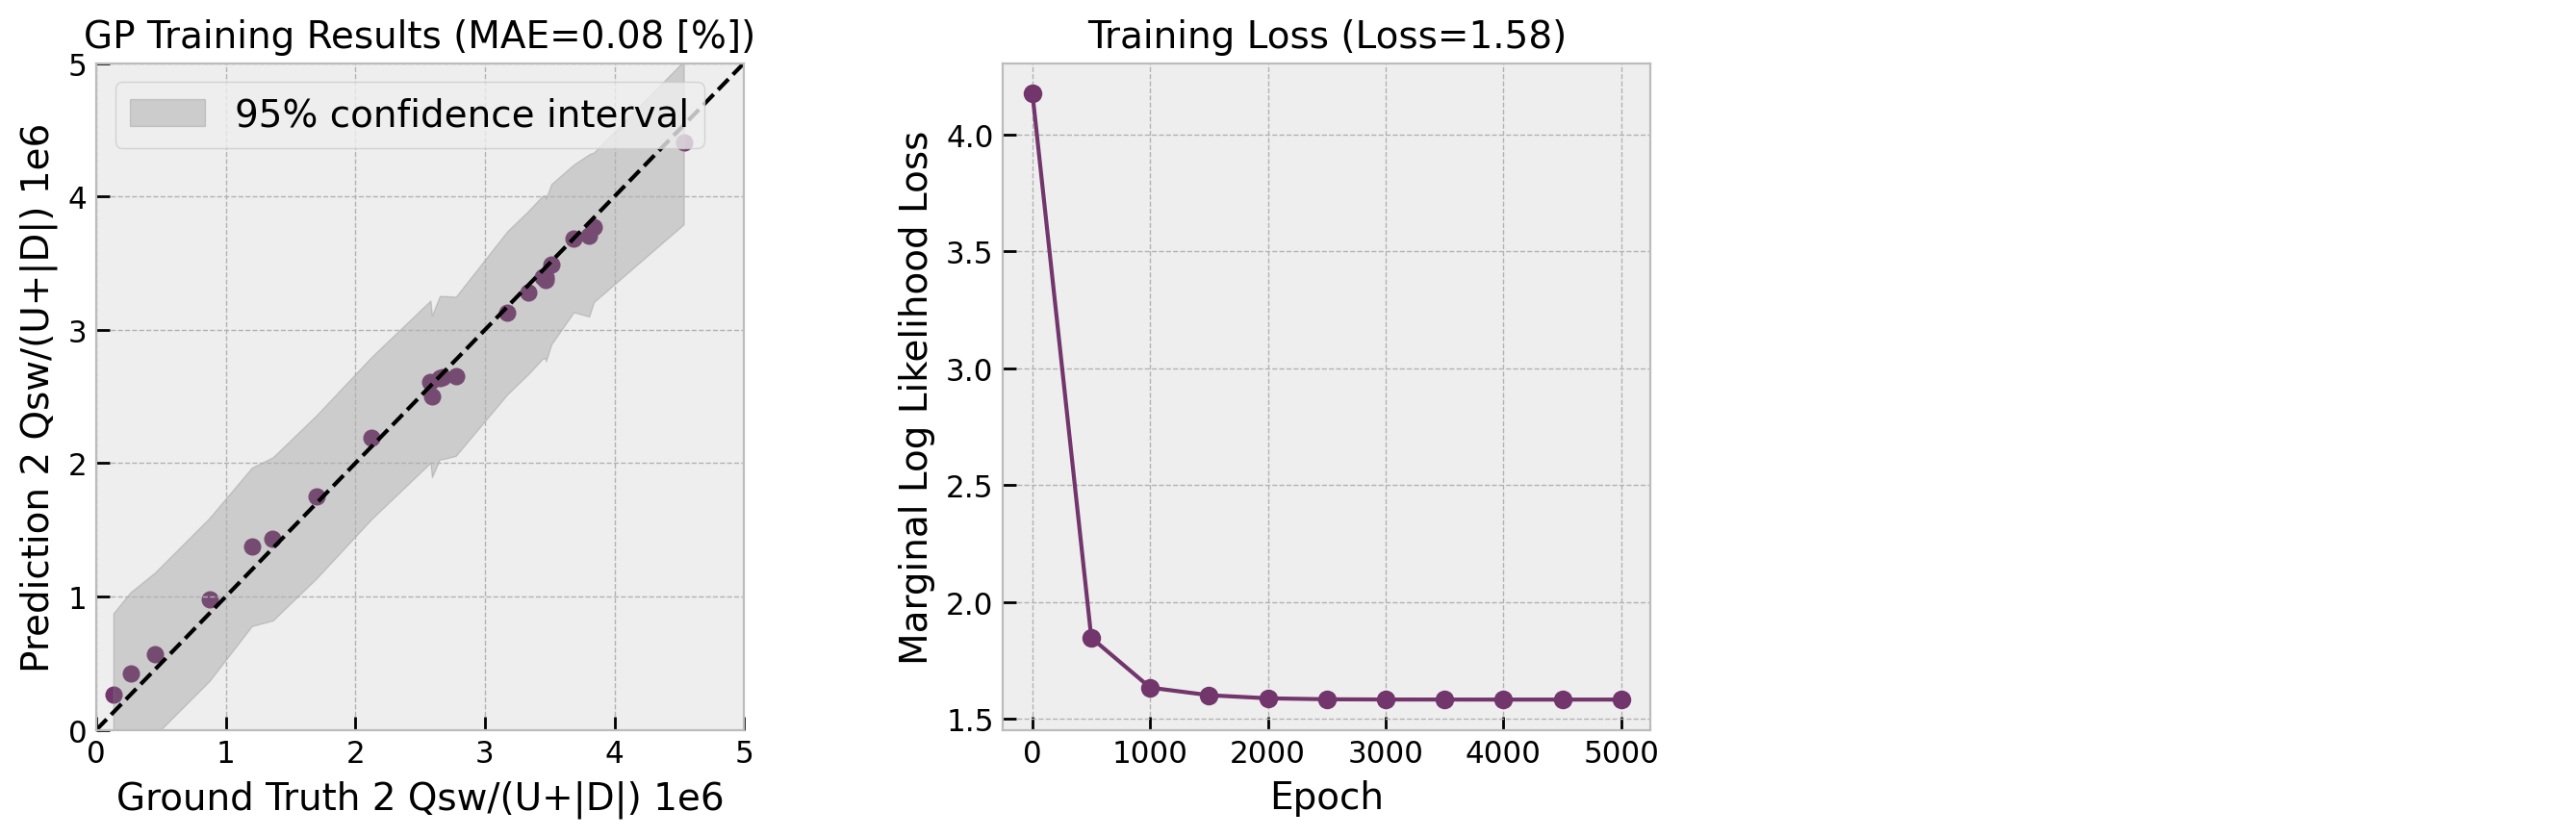

In [260]:
round_three = lambda val: np.round(val, 3) 
model.eval(), likelihood.eval()
y_preds = likelihood(model(train_x))
f_var = model(train_x).variance

model.eval(), likelihood.eval()
y_preds_test = likelihood(model(test_x))
f_var_test = model(test_x).variance

with torch.no_grad(): y_preds_mean, f_var = y_preds.mean.numpy(), np.sqrt(f_var).numpy()
with torch.no_grad(): y_preds_test_mean, f_var_test = y_preds_test.mean.numpy(), np.sqrt(f_var_test).numpy()
plot_gp_res(train_y, y_preds_mean, loss_lst, f_var)
# plot_gp_res(test_y, y_preds_test_mean, None, f_var_test, train_or_test= "test")

In [261]:
# acquisition function for prediction/exploration
def get_bounds(n): return [n for i in range(config.dim)]

def unravel_acq(acq_func, obs, bounds, train_y, nshape):
    """ 
    [unravel_acq(acq_func, obs, bounds, train_y, nshape)] is a helper function 
    for acq that returns the coordinates of the maximum value of the acq_func 
    over the test grid in the form of a tuple (row_index, column_index). 

    row_index = index into time
    column_index = index into energy density
    """
    acq = acq_func(obs, bounds, train_y).detach().numpy().reshape(nshape).T
    return np.unravel_index(acq.argmax(), acq.shape)

def acq(obs, train_y, bounds):
    """ 
    [acq(obs, train_y, bounds)] evaluates acquisition functions on current 
    predictions (observations) and outputs suggested points for exploration 
    on manifold. 
    """
    transpose = lambda tensor: tensor.detach().numpy().reshape(nshape).T
    nshape = tuple(bounds)

    pi = unravel_acq(PI, obs, bounds, train_y, nshape) # prob of improvement
    ei = unravel_acq(EI, obs, bounds, train_y, nshape) # expected improvement
    ca = unravel_acq(cust_acq, obs, bounds, train_y, nshape) # custom acq
    th = unravel_acq(thompson, obs, bounds, train_y, nshape) # thompson acq

    lower, upper = obs.confidence_region()
    upper_surf, lower_surf = transpose(upper), transpose(lower)
    ucb = np.unravel_index(upper_surf.argmax(), upper_surf.shape)

    pred_var = obs.variance.view(nshape).detach().numpy().T
    pred_labels = obs.mean.view(nshape).T
    max_var = np.unravel_index(pred_var.argmax(), pred_var.shape)

    # acqs gives pairs corresponding to indices of time and energy density 
    # recommendations in grid; the pairs index into array pred_labels 
    acqs = {"PI":pi, "EI":ei, "CA":ca, "TH":th, "UCB":ucb, "Max_var":max_var}

    return pred_labels, upper_surf, lower_surf, acqs

In [262]:
# export predictions to csv
def pred_to_csv(acqs, raw_pred_labels, raw_test_grid, file_out = "preds.csv"):
    """
    [pred_to_csv(acqs, raw_pred_labels, raw_test_grid)] outputs suggested
    inputs and their respective predicted outputs to csv; returns suggested point
    corresponding to ucb acquisition.
    """   
    dir = "/Users/valenetjong/Bayesian-Optimization-Ferroelectrics/predictions/"
    file = open(dir + file_out, "w", encoding="utf-8")
    file.write("Energy density \t Time (ms)\n")
    data = {'Time(ms)':[], 'Energy density new cone (J/cm^2)':[], '2 Qsw/(U+|D|) 1e6':[]}
    ucb = []
    for lab, coords in acqs.items(): 
        time_val = raw_test_grid[coords[1]].tolist()[0]
        energy_den_val = raw_test_grid[coords[0]].tolist()[1]
        data['Time(ms)'].append(time_val)
        data['Energy density new cone (J/cm^2)'].append(energy_den_val)
        file.write(lab + ": " + str(time_val) + "\t" + str(energy_den_val) + "\n")
        if lab == "UCB": ucb.append(time_val*1000), ucb.append(energy_den_val)  # change units μs

    file.write("\nFigure of merit\n")
    for lab, coords in acqs.items():
        fig_of_merit = raw_pred_labels[coords].item()
        data['2 Qsw/(U+|D|) 1e6'].append(fig_of_merit)
        file.write(lab + ": " + str(fig_of_merit) + "\n")
        if lab == "UCB": ucb.append(fig_of_merit)

    df = pd.DataFrame(data)
    print(df)
    return ucb


In [263]:
# get normalized predictions
bounds = get_bounds(n=30)
pred_labels, upper_surf, lower_surf, acqs = acq(obs, train_y, bounds)

# undo scaling
raw_train_x, raw_test_grid = un_norm_x(train_x, test_grid, scaler)


### Save Predictions and Visualize 

In [264]:
# undo normalization and save to csv, get prediction point
ucb = pred_to_csv(acqs, pred_labels, raw_test_grid)

# suggested points (μs, J/cm^2)
ucb_pt, nlcd_pt = (round(ucb[0],-1),round(ucb[1],2)), (2900, 9.04)
print(ucb_pt)

   Time(ms)  Energy density new cone (J/cm^2)  2 Qsw/(U+|D|) 1e6
0  1.503079                          8.850209           3.766922
1  1.503079                          8.850209           3.766922
2  4.828202                         14.954765           2.590935
3  4.163177                          3.215234           2.459247
4  1.503079                          8.850209           3.766922
5  1.669335                          2.276071           2.459332
(1500.0, 8.85)


In [265]:
# sanity check for fig of merit from acquisition
model.eval(), likelihood.eval()
ucb = np.array((1.17, 8.85)).reshape(1,2)
ucb_scaled = scaler.transform(ucb)
print(ucb_scaled)

y_preds_ucb = likelihood(model(torch.Tensor(ucb_scaled)))

with torch.no_grad(): y_preds_ucb_mean = y_preds_ucb.mean.numpy()
print(y_preds_ucb_mean)

[[0.14888889 0.48151064]]
[2.4845996]


/Users/valenetjong/opt/anaconda3/envs/FEGP/lib/python3.9/site-packages/gpytorch/likelihoods/gaussian_likelihood.py:270: GPInputWarning:

You have passed data through a FixedNoiseGaussianLikelihood that did not match the size of the fixed noise, *and* you did not specify noise. This is treated as a no-op.



In [266]:
import plotly.graph_objects as go
def vis_pred(train_x, train_y, test_grid, pred_labels):
    fig = go.Figure(data=[go.Surface(z=pred_labels.numpy(), 
                                    x=test_grid[:,0],
                                    y=test_grid[:,1],
                                    opacity = 0.8,
                                    colorscale = "Burg",
                                    colorbar=dict(thickness=15, len=0.5),
                                    name='GP regression')])
    
    fig.add_trace(go.Scatter3d(x=train_x[:,0],
                              y=train_x[:,1],
                            z=train_y.numpy(), mode='markers', 
                            marker={'color':'#72356c'}, name='training data'))
    fig.update_layout(width=1000, height=800,
                    legend=dict(orientation="h", yanchor="top", y=1.02, 
                    xanchor="left",x=1), margin=dict(r=20, l=10, b=10, t=10), 
                        scene=dict(
                        xaxis_title="Pulse Width (msec)",
                        yaxis_title="Energy density new cone (J/cm^2)",
                        zaxis_title='2 Qsw/(U+|D|) 1e6')
                    )
    fig.update_layout(template="ggplot2")
    camera = dict(up=dict(x=0, y=0, z=1), center=dict(x=0, y=0, z=0),
                    eye=dict(x=2.75, y=1.75, z=1))
    fig.update_layout(scene_camera=camera)
    fig.show()

In [267]:
# visualize acquisition function results and confidence bound surfaces
vis_pred(raw_train_x, train_y, raw_test_grid, pred_labels)

In [268]:
import plotly.graph_objects as go
def vis_acq(train_x, train_y, test_grid, pred_labels, upper_surf, lower_surf, acqs):
    fig = go.Figure(data=[go.Surface(z=pred_labels.numpy(), 
                                    x=test_grid[:,0],
                                    y=test_grid[:,1],
                                    opacity = 0.8,
                                    colorscale = "Burg",
                                    colorbar=dict(thickness=15, len=0.5),
                                    name='GP regression')])

    fig.add_trace(go.Surface(z=upper_surf, x=test_grid[:,0],
                    y=test_grid[:,1], opacity=0.2, colorscale = "Burg", showscale=False))

    fig.add_trace(go.Surface(z=lower_surf, x=test_grid[:,0],
                            y=test_grid[:,1], 
                            colorscale = "Burg",
                            opacity=0.2, showscale=False))
    fig.add_trace(go.Scatter3d(x=train_x[:,0], 
                                y=train_x[:,1], 
                                z=train_y.numpy(), 
                                mode='markers', 
                                name='training data', 
                                marker={'color':'#72356c'}))
    
    for acq_name, acq_val in acqs.items():
        fig.add_trace(go.Scatter3d(x=[test_grid[acq_val[1], 0]], 
                                y=[test_grid[acq_val[0], 1]],
                                z=[pred_labels[acq_val[0], acq_val[1]]], mode='markers', 
                                name='max(' + acq_name + ')')) 

    fig.update_layout(width=1200, height=750,
                    margin=dict(r=20, l=10, b=15, t=10),
                    legend=dict(orientation="h", yanchor="bottom", 
                                y=0.9, xanchor="right",x=0.85),
                    scene=dict(
                        xaxis_title="Pulse Width (msec)",
                        yaxis_title="Energy density new cone (J/cm^2)",
                        zaxis_title='2 Qsw/(U+|D|) 1e6')
                    )

    fig.update_layout(template="ggplot2")
    camera = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=2, y=0.3, z=0.75))

    fig.update_layout(scene_camera=camera)

    fig.show()
    # fig.write_image("output_plot.png", format = "png", scale=3)

In [269]:
vis_acq(raw_train_x, train_y, raw_test_grid, pred_labels, upper_surf, lower_surf, acqs)

In [270]:
# check fig of merit of julia et al prediction point
model.eval(), likelihood.eval()
nlcb = np.array((2.9, 9.04)).reshape(1,2)
nlcb_scaled = scaler.transform(nlcb)
print(nlcb_scaled)

y_preds_nlcb = likelihood(model(torch.Tensor(nlcb_scaled)))

with torch.no_grad(): y_preds_nlcb_mean = y_preds_nlcb.mean.numpy()
print(y_preds_nlcb_mean)

[[0.53333333 0.4964595 ]]
[2.4592438]


/Users/valenetjong/opt/anaconda3/envs/FEGP/lib/python3.9/site-packages/gpytorch/likelihoods/gaussian_likelihood.py:270: GPInputWarning:

You have passed data through a FixedNoiseGaussianLikelihood that did not match the size of the fixed noise, *and* you did not specify noise. This is treated as a no-op.



### Post-processing
- Energy density, pulse width --> voltage function

In [271]:
import GPy
from GPy.models import GPRegression
from emukit.model_wrappers import GPyModelWrapper
from torch.optim import Adam as Adam
from emukit.core import ParameterSpace, ContinuousParameter

#### Load Data

In [272]:
dir = "/Users/valenetjong/Bayesian-Optimization-Ferroelectrics/data/"
in_file = "MKS_Ophir_joulemeter_readings.xlsx"
df = pd.read_excel(dir + in_file, sheet_name="Sheet2")
df = df.dropna().sort_values("Voltage Setting") # Drop rows with NaN values, sort
print(df)

time_bol_dat = df['Pulse width'].values
energy_den_bol_dat = df['optical read (J/cm^2)'].values
volts_bol_dat = df['Voltage Setting'].values

# define scaler
post_scaler = MinMaxScaler()

# make, scale training set
x_exp_raw = np.stack((time_bol_dat, energy_den_bol_dat), axis=1)
x_exp = post_scaler.fit_transform(x_exp_raw)

y_exp = np.reshape(volts_bol_dat,(-1,1))
X, Y = [x_exp, y_exp]

     Voltage Setting  Pulse width  optical read (J/cm^2)
111           1950.0       5000.0                   8.80
102           1950.0        500.0                   1.37
103           1950.0       1000.0                   2.70
104           1950.0       1500.0                   3.84
105           1950.0       2000.0                   4.83
..               ...          ...                    ...
65            2800.0       2000.0                  12.08
64            2800.0       1500.0                   9.91
63            2800.0       1000.0                   7.22
91            3000.0       5000.0                  21.81
83            3000.0       1000.0                  10.27

[92 rows x 3 columns]


#### GP Voltage Model

In [273]:
def grid_maker_1D(arr, step_size):
    return np.arange(arr.min(), arr.max()+step_size*0.1,step_size)

# make GP grid; min delta time: 500us, min delta energy density: 0.01J/cm^2
var_array = [grid_maker_1D(time_bol_dat, 500), grid_maker_1D(energy_den_bol_dat, 0.01)]

In [274]:
# continuous parameter creates a grid space for grid search
time_len_num, e_den_num = len(var_array[0]), len(var_array[1])
parameter_space = ParameterSpace([ContinuousParameter("Time (ms)", 0-1/(time_len_num-1)/2, 1+1/(time_len_num-1)/2),
                                  ContinuousParameter("Energy density new cone (J/cm^2)", 0-1/(e_den_num-1)/2, 1+1/(e_den_num-1)/2),
                                 ])

In [275]:
# define GP model
kernel = GPy.kern.src.stationary.Exponential(input_dim = len(X[0]), ARD =True)
kernel.lengthscale.constrain_bounded(1e-2, 1)
kernel.variance.constrain_bounded(1e-2, 500.0)
model_volt = GPRegression(X , -Y, kernel)   # optimize thru minimization
model_volt.Gaussian_noise.variance = 0.15
model_volt.Gaussian_noise.variance.fix()

reconstraining parameters Exponential.lengthscale
reconstraining parameters Exponential.variance


array([0])

In [276]:
# randomize hyperparameters
model_volt.randomize() 

# check hyperparameters 
# print(kernel.lengthscale, '\n', kernel.variance)
print(kernel)

  Exponential.  |               value  |  constraints  |  priors
  variance      |  329.57578604469705  |  0.01,500.0   |        
  lengthscale   |                (2,)  |   0.01,1.0    |        


In [277]:
# train voltage model
model_volt.optimize_restarts(num_restarts=30, verbose =False, messages=False) # fit to training data, select best hyperparameters out of num_restarts 
objective_model = GPyModelWrapper(model_volt)
# print(objective_model.model.kern.lengthscale, '\n', objective_model.model.kern.variance)
print(kernel)

  Exponential.  |               value  |  constraints  |  priors
  variance      |  499.99999928622094  |  0.01,500.0   |        
  lengthscale   |                (2,)  |   0.01,1.0    |        


In [278]:
# predict voltage training set
gp_func =  objective_model.model.predict
y_pred, y_err = gp_func(X)
y_pred, y_err = -y_pred[:,-1], np.sqrt(y_err[:,-1])

     Metric  Value
0      RMSE  8.244
1       MAE  2.800
2  Spearman  0.992
3  R² score  0.999


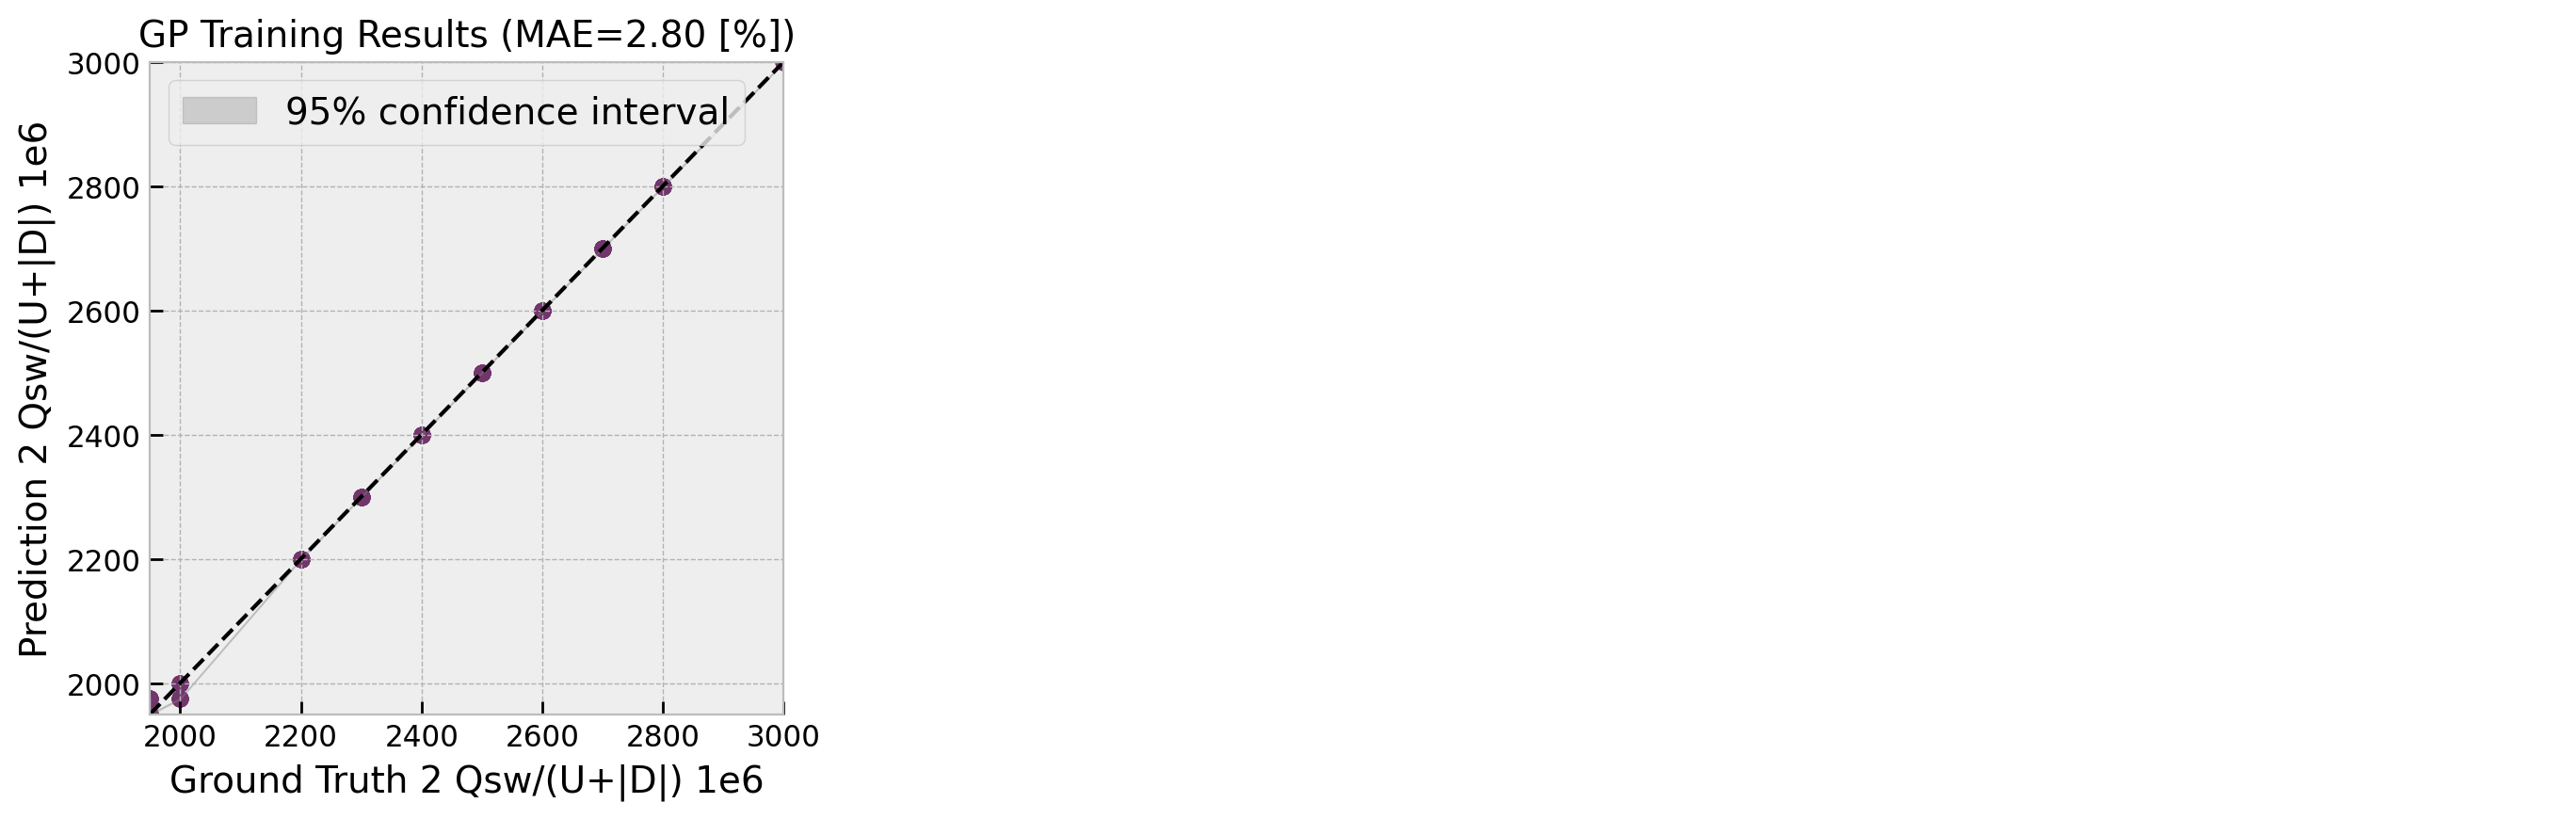

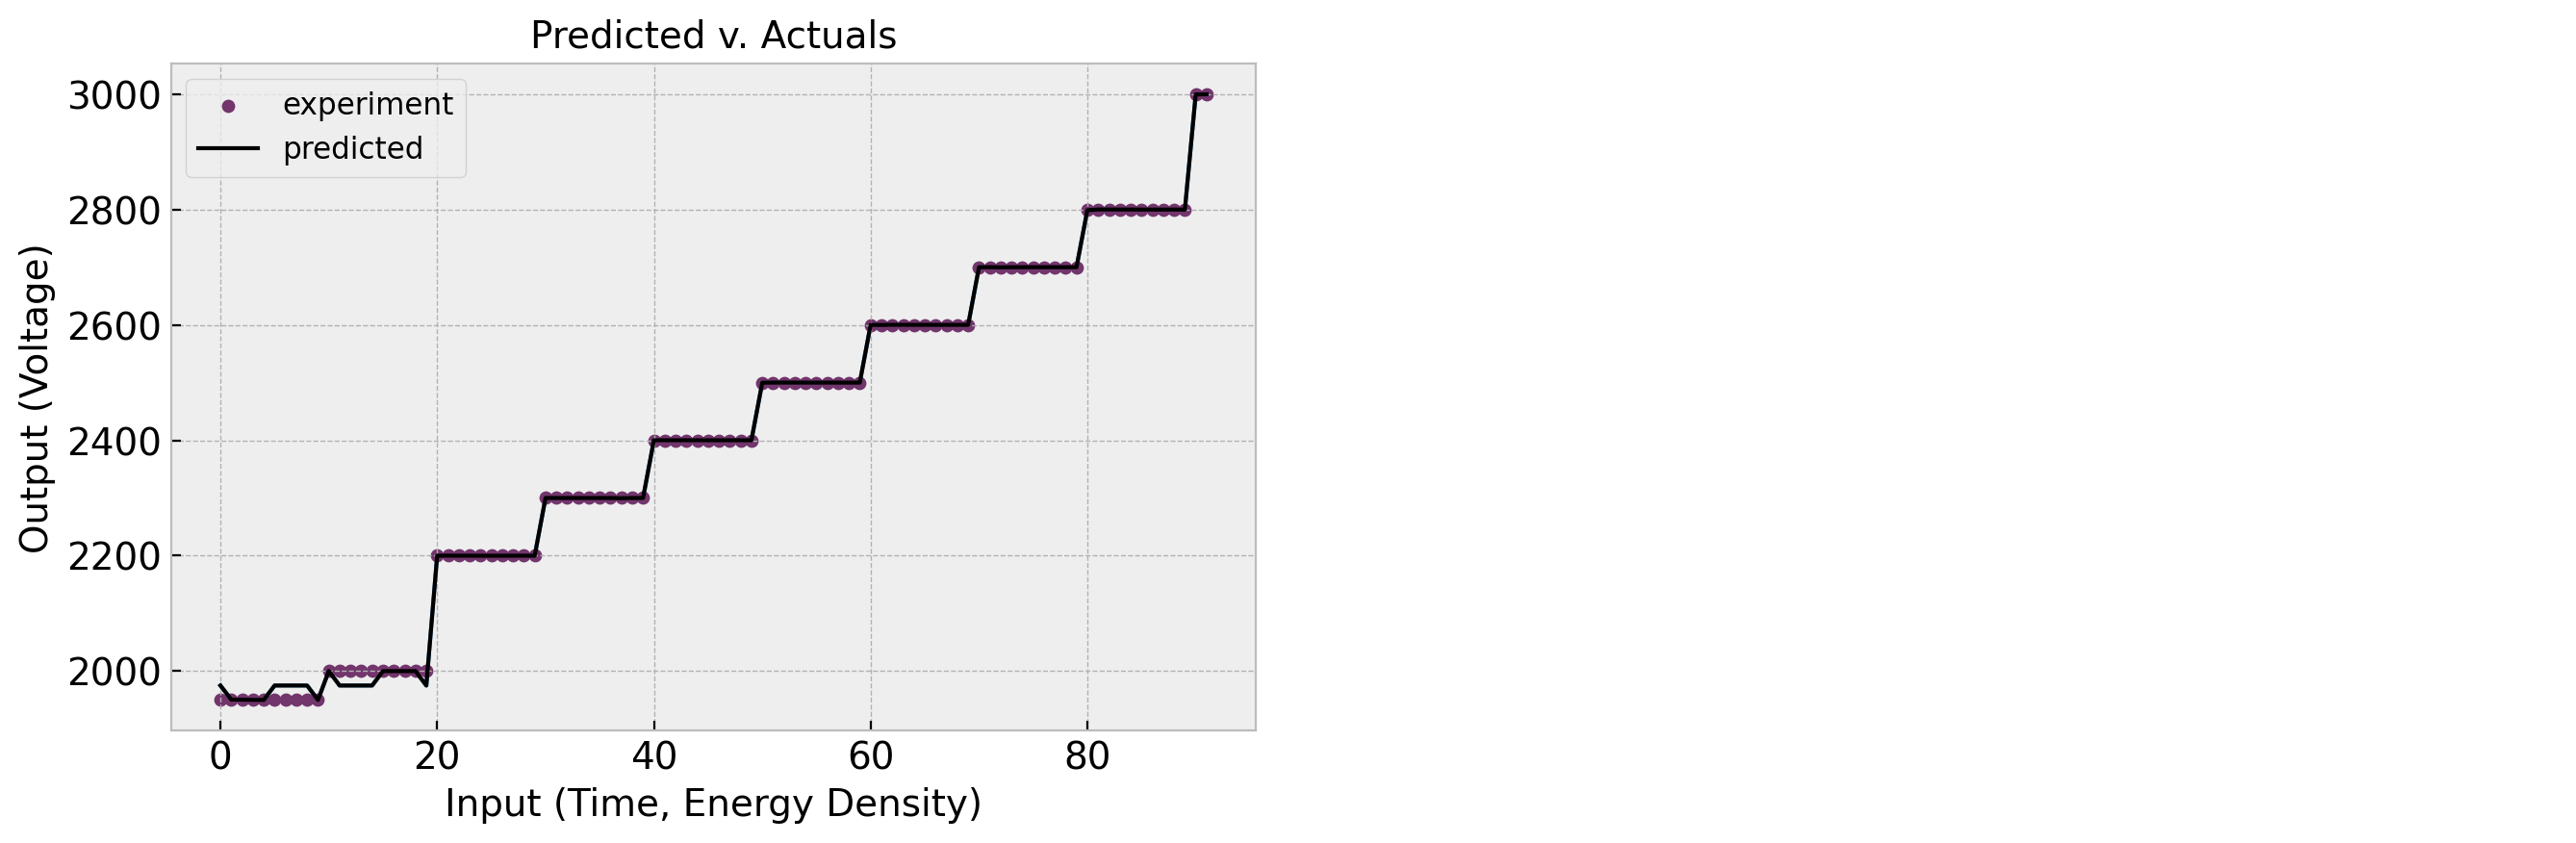

In [279]:
# plot voltage training results 
plot_gp_res(y_exp.reshape(-1), y_pred, None, y_err)
prettyplot()

# plot actuals v. predicted values w/ error bars
fs = 14 
fig, axes = plt.subplots(1, 2, figsize=(16, 4.5))
plt_inputs = np.arange(len(Y))
axes[0].scatter(plt_inputs, Y[:,0].T, s = 20, color = "#72356c", label = 'experiment')
axes[0].plot(plt_inputs, y_pred, color = 'black', label = 'predicted')
axes[0].errorbar(plt_inputs, y_pred, y_err, zorder = 0)

# set up axes and labels
axes[0].set_ylabel('Output (Voltage)', fontsize = fs)
axes[0].set_xlabel('Input (Time, Energy Density)', fontsize = fs)
axes[0].set_title("Predicted v. Actuals", fontsize = fs)
axes[0].legend(fontsize = fs*0.8)
axes[1].axis("off")

plt.show()

In [280]:
# get voltage of prediction points and re-scale to raw
get_pos_volt = lambda pt: round(-1*(gp_func(pt)[0].item()),-2)
ucb_pt, nlcd_pt = np.array(ucb_pt).reshape(1,2), np.array(nlcd_pt).reshape(1,2)
ucb_pt_scaled, nlcd_pt_scaled = post_scaler.transform(ucb_pt), post_scaler.transform(nlcd_pt)
ucb_pt, nlcd_pt = ucb_pt.reshape(-1), nlcd_pt.reshape(-1)
ucb_pt_time, ucb_pt_eden, ucb_pt_volt = ucb_pt[0]/1000, ucb_pt[1], get_pos_volt(ucb_pt_scaled)
nlcd_pt_time, nlcd_pt_eden, nlcd_pt_volt = nlcd_pt[0]/1000, nlcd_pt[1], get_pos_volt(nlcd_pt_scaled)

# write to csv
dir = "/Users/valenetjong/Bayesian-Optimization-Ferroelectrics/predictions/"
file_out = "final_preds.csv"
file = open(dir + file_out, "a", encoding="utf-8")
file.write("GP fit predictions: \n")
file.write("Type\t Time (ms)\t Energy density(J\cm^2)\t Voltage()\n")
file.write("UCB:\t" + str(ucb_pt_time) + "\t" + str(ucb_pt_eden) +"\t" + str(ucb_pt_volt) + "\n")
file.write("NLCB:\t" + str(nlcd_pt_time) + "\t" + str(ucb_pt_eden) +"\t" + str(nlcd_pt_volt) + "\n")

22

#### Plot GP Function, Scipy Optimize Function, against Raw Data

In [281]:
# make, scale post_test_grid
_, _, post_test_grid, post_test_arr = grid_maker(torch.Tensor(X))
volt_on_grid, _ = gp_func(post_test_arr.numpy())
volt_on_grid = -1 * volt_on_grid.reshape(30,30).T
raw_post_test_arr, raw_post_test_grid = un_norm_x(post_test_arr, post_test_grid, post_scaler)

In [282]:
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib as mpl

fig = go.Figure(data=[go.Scatter3d(z=volts_bol_dat, 
                                    x=time_bol_dat,
                                    y=energy_den_bol_dat, 
                                    mode='markers',
                                    marker={'color':'darkgreen'},
                                    name='GP regression')])
fig.add_trace(go.Surface(z=volt_on_grid, 
                            x=raw_post_test_grid[:,0],
                            y=raw_post_test_grid[:,1],
                            opacity=0.8,
                            colorbar=dict(thickness=15, len=0.5)))

fig.update_layout(width=1000, height=800,
                    legend=dict(orientation="h", yanchor="top", y=1.02, 
                    xanchor="left",x=1), margin=dict(r=20, l=10, b=10, t=10), 
                        scene=dict(
                        xaxis_title="Pulse width (μs)",
                        yaxis_title="Energy density new cone (J/cm^2)",
                        zaxis_title='Voltage')
                    )
camera = dict(
        up=dict(x=0, y=0, z=1),
        center=dict(x=0, y=0, z=0),
        eye=dict(x=-2, y=-2.5, z=1.75)
)
fig.update_layout(scene_camera=camera)
fig.show()